In [4]:
## Michael Gallotta
## dunkins per capita.ipynb
## 2019/05/05
##
## scrapes data from menuism.com of locations of dunkin (donuts) in the state of MA
##
## output pandas df contains street addresses, 
## town, zip code, and state. 
##


import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import csv
import geopandas as gpd
from matplotlib import pyplot as plt

menuism = "https://www.menuism.com/restaurant-locations/dunkin-donuts-181624/us/ma"
MA_WIKI = "https://en.wikipedia.org/wiki/List_of_municipalities_in_Massachusetts"

In [5]:
# requests data from the menuism website
page = requests.get(menuism)
html = page.content

soup = bs(html, "html.parser")
parse_soup = soup.find_all("ul", {"class":"list-unstyled-links"})

dd_towns = parse_soup[0].find_all("li",recursive=False)

In [6]:
menuism_town = []
menuism_dd_count = []

for tags in dd_towns:
    if tags.h5:
        # if the tag h5 is present, then there are multiple dd's in the town.
        # finds the town name
        multi_town_tag_string = tags.h5['id']
        #checks for a dash in the town name eg "South-Yarmouth"
        drop_dash = multi_town_tag_string.replace("-"," ")
        menuism_town.append(drop_dash.title())
        # gets the count of DD locations, located next to the h5 tag as text wrapped in parenthesis 
        count_string = tags.h5.text
        menuism_dd_count.append(int(count_string[count_string.find("(")+1:count_string.find(")")]))
    else:
        single_town_tag_string = tags.a['title']
        menuism_town.append(single_town_tag_string[18:single_town_tag_string.find(",")])
        menuism_dd_count.append(1)
        
d1 = {'Town' : menuism_town, 'Count' : menuism_dd_count}

menuism_df1 = pd.DataFrame(data = d1)

In [7]:
static_csv='static_no_match.csv'

with open(static_csv, newline='') as csv_file:
    match_reader = csv.reader(csv_file, delimiter=',')
    corrected_ls = list(match_reader)
    
corrected_df1 = pd.DataFrame(data = corrected_ls, columns = ['No Match','Town','Count'])

corrected_df1.Count = corrected_df1.Count.astype(int)

corrected_df2 = pd.DataFrame(data = corrected_df1.groupby('Town', as_index=False).agg({'Count': 'sum'}))

corrected_df3 = pd.concat([corrected_df2,menuism_df1])

corrected_df4 = pd.DataFrame(data = corrected_df3.groupby('Town', as_index=False).agg({'Count': 'sum'}))

In [8]:
# requests data from wikipedia

page = requests.get(MA_WIKI)
html = page.content 

# searches page for the table containing population data 

soup = bs(html, "html.parser")
parse_soup = soup.find_all("td",{"align":"right"})

# goes for population first, returns an int value

wiki_town_pop = []
for pop in parse_soup:
    string_pop = pop.text
    int_pop = int(string_pop.replace(',', ''))
    wiki_town_pop.append(int_pop)
    
# parses for towns in same table. knowing there are 
# only 351 incorporated towns in MA, I created an index for the table. 

parse_soup = soup.find_all("tr")

wiki_town = []
for items in parse_soup[1:352]:
    towns = items.find("a")
    wiki_town.append(towns.text)
    
    
d2 = {'Town':wiki_town, 
      'Pop 2010':wiki_town_pop}

wiki_df1 = pd.DataFrame(data = d2, index = list(range(351)))

In [9]:
# finding per capita values

df_final = pd.merge(corrected_df4,wiki_df1, on = 'Town')
df_final['DD Per 1k'] = ((df_final['Count']/df_final['Pop 2010'])*1000)#.astype(int)
#df_final['DD Per 1k'] = (df_final['Pop 2010']/df_final['Count']).astype(int)

# the idea here was to have an index that corresponded to 
# MassGIS standard for ID'ing towns 1-351. 
# eg Abington is 1, Yarmouth is 351. However, not every town listed
# on Menuism website refers to an incorprated city/town in MA, there are 
# 61 non-matches. These non-matches are contained in df4 (see below)

df_final.index += 1

df_final.sort_values(by=['DD Per 1k'],ascending=False)
#df_final.sort_values(by=['Town'],ascending=False)

df_final.to_csv("df_final")

In [10]:
df_final['Town'] = df_final['Town'].map(lambda name: name.upper())

In [11]:
# 'static_no_match.csv' is a hand typed match sheet that takes
#  unincorporated villages listed on menuism and translated them
#  to the corresponding, incorporated towns. this faciliates the 
#  join to the wikipedia census data.
#
#  this WILL NEED a check to make sure that all locations are matched
#
# error checking! 

'''
town_NOT_IN_MA_towns = []

for town in menuism_town:
    if town not in wiki_town:
        town_NOT_IN_MA_towns.append(towns)
'''

'\ntown_NOT_IN_MA_towns = []\n\nfor town in menuism_town:\n    if town not in wiki_town:\n        town_NOT_IN_MA_towns.append(towns)\n'

In [12]:
MA_towns_shp_path = "TOWNSSURVEY_POLYM.shp"

ma_map = gpd.read_file(MA_towns_shp_path)

In [13]:
merged = ma_map.set_index('TOWN').join(df_final.set_index('Town'))


#finds null features, null features will prevent mapping, as plot cannot do NaN values
#merged.isnull().sum()

#checks for all unique geometry
#merged['geometry'].unique()

merged['DD Per 1k'].fillna(value = 0, inplace = True)

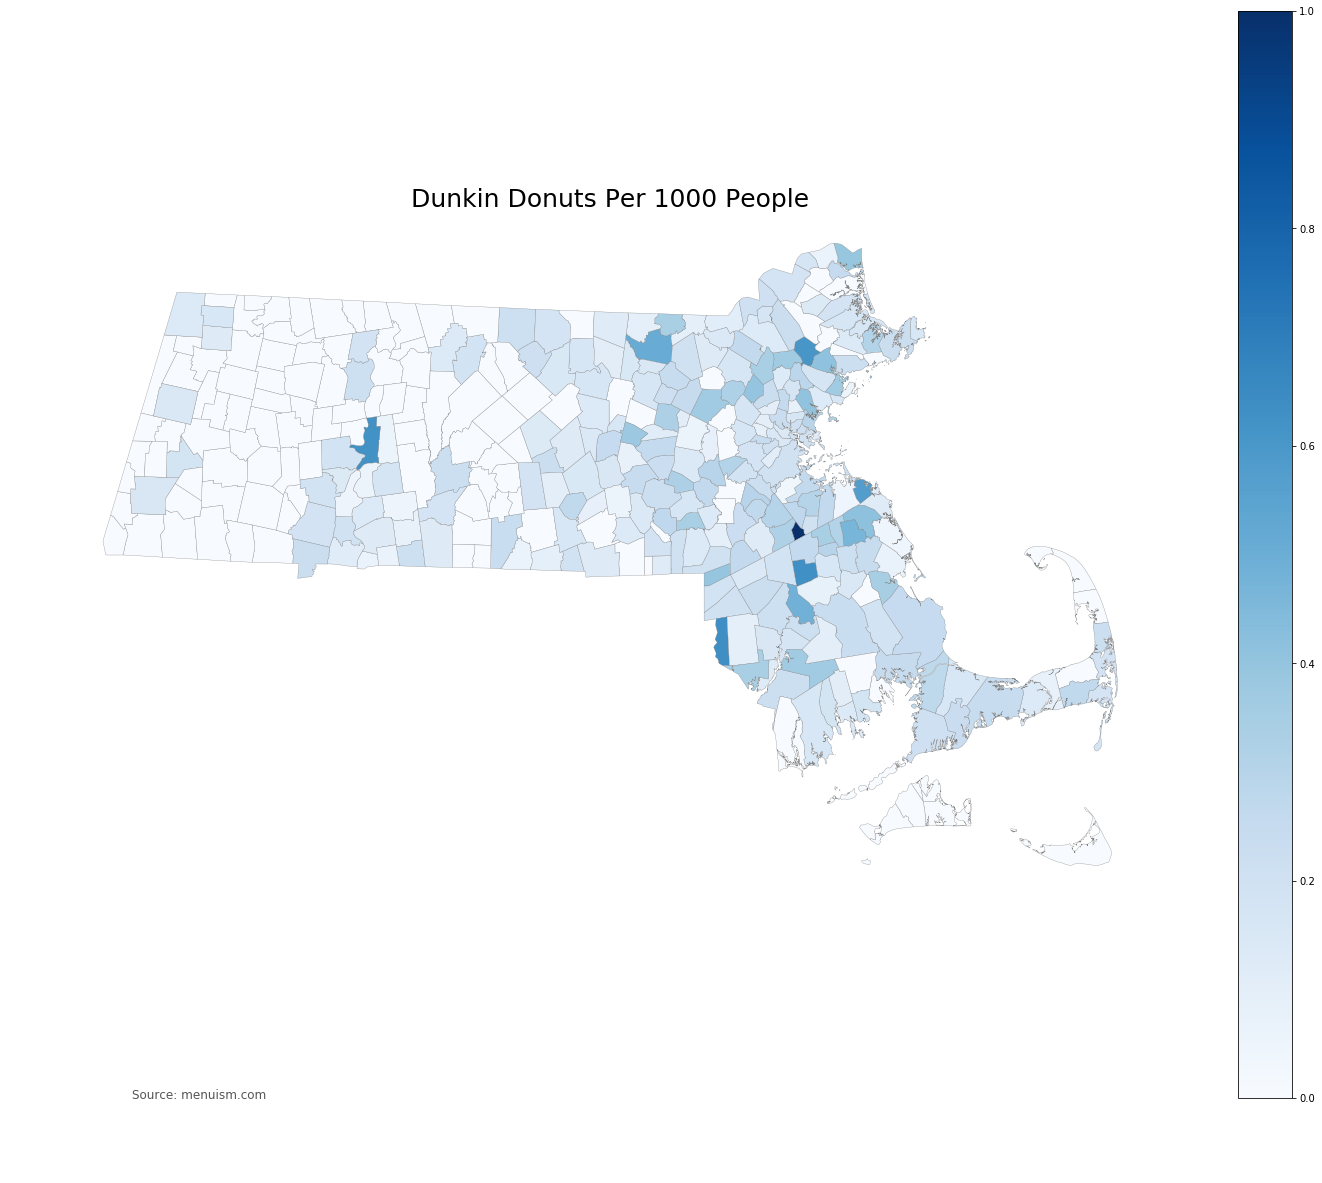

In [14]:
col = 'DD Per 1k'

# set the range for the choropleth
vmin, vmax = 0,1

# create figure and axes for Matplotlib
dd_map, ax = plt.subplots(figsize=(25, 20))

merged.plot(column=col, 
            cmap='Blues', 
            linewidth=0.3, 
            ax=ax,
            edgecolor='.5')

# no goofy looking axes
ax.axis('off')

# title
ax.set_title('Dunkin Donuts Per 1000 People', 
             fontdict={'fontsize': '25', 
                       'fontweight' : '3'}
            )

# annotation
ax.annotate('Source: menuism.com',
            xy = (0.1, .08),  
            xycoords='figure fraction', 
            horizontalalignment='left', 
            verticalalignment='top', 
            fontsize=12, 
            color='#555555'
           )

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=1))

# empty array for the data range
sm._A = []

# add the colorbar to the figure
cbar = dd_map.colorbar(sm)

In [15]:
dd_map.savefig("dd_map.png", dpi=150)

In [20]:
x = df_final.sort_values(by=['DD Per 1k'],ascending=False)

AttributeError: 'DataFrame' object has no attribute 'set_option'